# Access Google Drive Storage

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Import all required library



In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pandas as pd
import numpy as np
import seaborn as sn

# Load all the images and split into test and train

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/gdrive/My Drive/Dataset/test/flights"))
data = []
labels = []


for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]
  print(label)
  image = load_img(imagePath, target_size=(224, 224))
  image = img_to_array(image)
  image = preprocess_input(image)

  data.append(image)
  labels.append(label)


data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

[INFO] loading images...
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicopter
helicop

# Hyperparameter

In [ ]:
INIT_LR = 1e-4
EPOCHS = 25
BS = 30
#32

# Pre-Trained ResNet50 Model

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
[INFO] compiling model...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___

# Train model and Evaluate model Performance

In [ ]:
print("[INFO] training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS), steps_per_epoch=len(trainX) // BS, validation_data=(testX, testY), validation_steps=len(testX) // BS, epochs=EPOCHS)

print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

predIdxs = np.argmax(predIdxs, axis=1)

print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))


print("[INFO] saving flight detector model...")
model.save("/gdrive/My Drive/model/test_flights/")

[INFO] training head...
Epoch 1/25
83/83 [==============================] - 49s 552ms/step - loss: 1.2549 - accuracy: 0.4498 - val_loss: 0.5807 - val_accuracy: 0.7732
Epoch 2/25
83/83 [==============================] - 46s 553ms/step - loss: 0.6790 - accuracy: 0.7065 - val_loss: 0.4645 - val_accuracy: 0.8179
Epoch 3/25
83/83 [==============================] - 46s 551ms/step - loss: 0.5639 - accuracy: 0.7746 - val_loss: 0.4261 - val_accuracy: 0.8307
Epoch 4/25
83/83 [==============================] - 46s 555ms/step - loss: 0.5206 - accuracy: 0.7833 - val_loss: 0.3959 - val_accuracy: 0.8466
Epoch 5/25
83/83 [==============================] - 46s 552ms/step - loss: 0.5000 - accuracy: 0.7892 - val_loss: 0.3762 - val_accuracy: 0.8562
Epoch 6/25
83/83 [==============================] - 46s 553ms/step - loss: 0.4262 - accuracy: 0.8349 - val_loss: 0.3705 - val_accuracy: 0.8578
Epoch 7/25
83/83 [==============================] - 46s 558ms/step - loss: 0.3996 - accuracy: 0.8465 - val_loss: 0.376

# Plot Train and Loss values

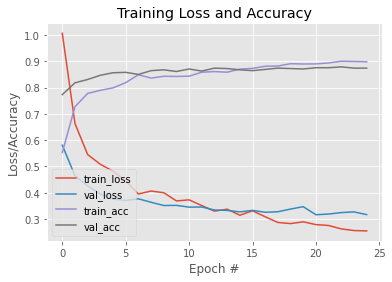

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(""])

# Draw Confusion Matrix to see model performance

In [ ]:
predictions = model.predict(testX, steps=len(testX),verbose =1)
y = np.argmax(predictions, axis=1)

626/626 [==============================] - 39s 61ms/step


Confusion Matrix
[[196   5   3]
 [ 13 184  20]
 [ 11  27 167]]


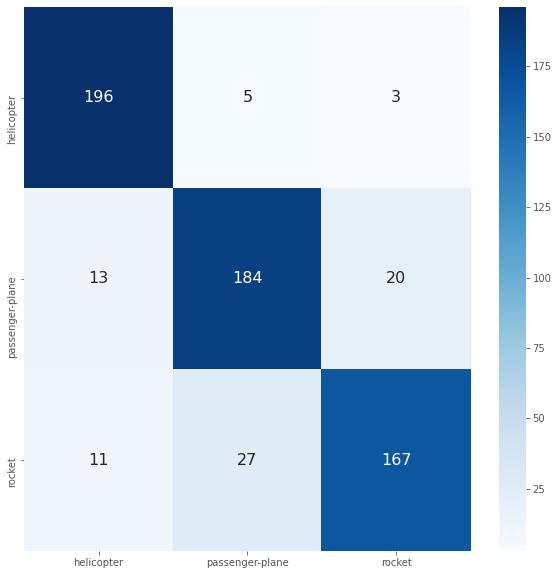

In [ ]:
print('Confusion Matrix')
classes = ['helicopter','passenger-plane','rocket']
cm = confusion_matrix(testY.argmax(axis=1), y)
print(cm)
df = pd.DataFrame(cm, index =classes, columns=classes)
plt.figure(figsize=(10,10))
sn.heatmap(df, cmap="Blues", annot=True,annot_kws={"size": 16},fmt='g')# font size
#sn.heatmap(df, annot=True)